In [1]:
%matplotlib inline
import platform
import cv2 #　opencvのインポート
import matplotlib
import matplotlib.pyplot as plt # matplotlib(描画用)
import numpy as np
import math, time
import random
from numba import jit, njit, prange, jitclass
from numba import f8, b1, i8, void, u1

print('python version: ' + platform.python_version())
print('opencv version: ' + cv2.__version__)
print('matplotlib version: ' + matplotlib.__version__)
print('numpy version: ' + np.__version__)

python version: 3.6.9
opencv version: 4.1.2
matplotlib version: 3.2.2
numpy version: 1.18.5


In [2]:
# このセルはGoogle Colaboratory使用時のみ必要
from google.colab import files
f = files.upload() # ファイルアップロード

Saving beach.png to beach (8).png
Saving grain.png to grain (2).png


> 9.3. Implement a graph-based segmenter, after Section 9.4.2.

以下, 自作したグラフによるセグメンタの実装を示す.

なお, 以下サイトを参考にした.

- Graph Based Image Segmentationについて  
http://cs.brown.edu/people/pfelzens/segment/

In [3]:
## Utilities
# パスから画像をRGBで取得
def GetImage(file_path, cv_option=cv2.COLOR_BGR2RGB, is_show=False):
  img = cv2.imread(file_path)
  img = cv2.cvtColor(img, cv_option)

  if is_show:
    plt.title('Acquired Image'), plt.xticks([]), plt.yticks([])
    plt.imshow(img)

  return img

# オリジナル画像を表示
def ShowOriginal(file_path):
  GetImage(file_path)
  plt.title('Original Image'), plt.xticks([]), plt.yticks([])
  plt.imshow(img)

In [4]:
# グラフ（重み付き無向グラフ）を用いたセグメンテーションを実行する
# img: 入力画像
# sigma: セグメンテーション前の平滑化用
# k: 内部差分の調整定数
# min_size: 最小クラスタ構成数
# @img_cluster: セグメンテーション結果画像
# @num_cluster: セグメンテーション結果のクラスタ数
def ExcecuteSegmentation(img, sigma, k, min_size):
  # 前処理として平滑化を行っておく
  blur = cv2.GaussianBlur(img, ksize=(0, 0), sigmaX=sigma)

  # グラフを構築
  edges = BuildGraph(blur)

  # セグメンテーション
  num_vertices = img.size / img.shape[2]
  ds = SegmentGraph(int(num_vertices), edges, k)

  # 後処理として要素数の少ないクラスタをマージ
  for edge in edges:
    a = ds.find(edge.id0)
    b = ds.find(edge.id1)
    if a != b and (ds.size(a) < min_size or ds.size(b) < min_size):
      ds.unite(a, b)

  # セグメント結果をもとに色分け
  img_cluster = ColorSegment(img, ds)
  return img_cluster, ds.get_cluster_num()


# エッジ
spec = [
        ("id0", i8),
        ("id1", i8),
        ("weight", f8)
]
@jitclass(spec)
class Edge:
  # id0, id1: 頂点id
  # w: エッジの重み
  def __init__(self, id0, id1, w):
    self.id0 = id0
    self.id1 = id1
    self.weight = w

# グラフ（エッジ群）を構築する
# img: 入力画像
# @edges: エッジ群
@njit
def BuildGraph(img):
  edges = []
  height, width, _ = img.shape
  
  # 各画素ごとに右, 右上, 右下, 下（4方向）との画素を繋ぐエッジの重みを計算する
  # 無向グラフなので反対側（+4方向）を計算しなくてよい
  for y in range(height):
    for x in range(width):
      id0 = y * width + x

      if x < width - 1: # 右
        id1 = y * width + (x+1)
        w = CalcDissimilarity(img, x, y, x+1, y)
        edges.append(Edge(id0, id1, w))
      
      if y < height - 1: # 下
        id1 = (y+1) * width + x
        w = CalcDissimilarity(img, x, y, x, y+1)
        edges.append(Edge(id0, id1, w))  
            
      if x < width - 1 and y < height - 1: # 右下
        id1 = (y+1) * width + (x+1)
        w = CalcDissimilarity(img, x, y, x+1, y+1)
        edges.append(Edge(id0, id1, w))
            
      if x < width - 1 and y > 0: # 右上
        id1 = (y-1) * width + (x+1)
        w = CalcDissimilarity(img, x, y, x+1, y-1)
        edges.append(Edge(id0, id1, w))
  
  return edges

# 2画素間の不同性:dissimilarityを計算
@njit(f8(u1[:,:,:], i8, i8, i8, i8))
def CalcDissimilarity(img, x1, y1, x2, y2):
  # 今回は2画素間の距離（2画素間の各RGB値の2乗和の平方根）をdissamilarityの値とした
  return np.sqrt(np.sum((img[y1, x1] - img[y2, x2]) ** 2))

# セグメント結果をランダムな色で着色化
def ColorSegment(img, ds):
  colored = np.empty_like(img)
  num_cluster = ds.get_cluster_num
  height, width, _ = img.shape

  # ランダムな色を生成
  rnd_c = lambda _: random.randint(0, 255)
  colors = [np.array([rnd_c(i), rnd_c(i), rnd_c(i)]) for i in range(height*width)]

  for y in range(height):
    for x in range(width):
      id = ds.find(y * width + x)
      colored[y, x] = colors[id]

  return colored

In [5]:
# 素集合データ構造の要素
class Element:
  def __init__(self, rank, id, size):
    self.rank = rank
    self.parent = id # 最初, ポインタは自身を指す
    self.size = size

# 素集合データ構造全体（Disjoint Set Forest）
# idを要素として持ち, 素集合のサイズも管理する
class DisjointSet:
  def __init__(self, size_elts):
    self.elts = [Element(0, i, 1) for i in range(size_elts)] # 要素の初期化
    self.num_cluster = size_elts
  
  # Find操作
  def find(self, x):
    # 経路圧縮を行いながら探索
    if x != self.elts[x].parent:
      self.elts[x].parent = self.find(self.elts[x].parent)
    return self.elts[x].parent

  # Union操作
  def unite(self, x, y):
    if x == y:
      return

    # 木の高さが高い方に合併する
    if self.elts[x].rank > self.elts[y].rank:
      self.elts[y].parent = x
      self.elts[x].size += self.elts[y].size
    else:
      self.elts[x].parent = y
      self.elts[y].size += self.elts[x].size

      # 木の高さが等しい場合のみ高さが上昇
      if self.elts[x].rank == self.elts[y].rank:
        self.elts[y].rank += 1
    
    # 合併後はクラスタ数が減る
    self.num_cluster -= 1
  
  def size(self, x):
    return self.elts[x].size
  
  def get_cluster_num(self):
    return self.num_cluster

In [6]:
# クラスタ内部差の補正項
# Felzenszwalb and Huttenlocher (2004)
def ThresholdTerm(size, k):
  return k / size

# グラフと素集合データ構造を用いてセグメンテーションを行う
def SegmentGraph(num_vertices, edges, k):
  # 素集合データ構造を作成
  ds = DisjointSet(num_vertices)

  # クラスタ内部差（閾値）の初期化
  ini_diff = ThresholdTerm(1, k)
  inter_diff = np.full(num_vertices, ini_diff, dtype="float")

  # エッジ群を重みで昇順にソート
  edges = sorted(edges, key=lambda e: e.weight)

  # エッジを切ってクラスタ間がマージできるかを判定していく
  for edge in edges:
    a = ds.find(edge.id0)
    b = ds.find(edge.id1)

    # エッジの2つの頂点が同じクラスタに属していない
    if a != b:
      # かつ, クラスタ内部差よりもエッジの重みが小さいとき
      if edge.weight <= inter_diff[a] and edge.weight <= inter_diff[b]:
        # 2つのクラスタを合併する
        ds.unite(a, b)

        # クラスタ内部差を更新
        id = ds.find(a)
        inter_diff[a] = edge.weight + ThresholdTerm(ds.size(a), k)

  return ds

以下, 次の順序で実行した様子を示す  
- 画像読み込み
- グラフによるセグメンテーションの実行
- 実行結果から色分けしたセグメントと分割クラスタ数を表示

なお, パラメータは経験則的に一番良く分割できたものを記載している.  
これらのパラメータは上に示した参考サイトをもとにしている.  

同じパラメータでも参考サイトやPDFの結果と異なる部分があるのは, 画像ダウンロード,   
拡張子変換時のデータの変更や, 前処理のぼかしの部分の相違などが原因として考えられる.

(300, 200, 3)


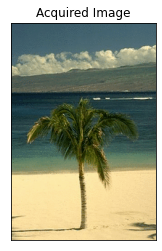

In [7]:
# 画像の読み込み
path = 'beach.png'
img = GetImage(path, is_show=True)
print(img.shape)

In [8]:
res, num_cluster = ExcecuteSegmentation(img, 0.5, 1000, 100)

cluster num: 28


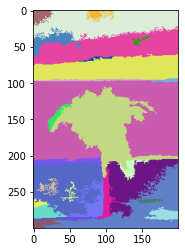

In [9]:
print("cluster num: " + str(num_cluster))
plt.imshow(res)

もう一つの例

(200, 300, 3)


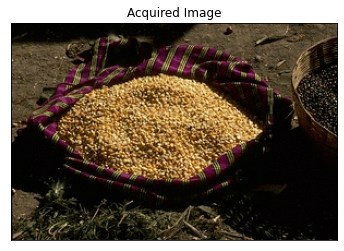

In [10]:
# 画像の読み込み
path = 'grain.png'
img = GetImage(path, is_show=True)
print(img.shape)

In [11]:
res, num_cluster = ExcecuteSegmentation(img, 0.5, 1200, 150)

cluster num: 21


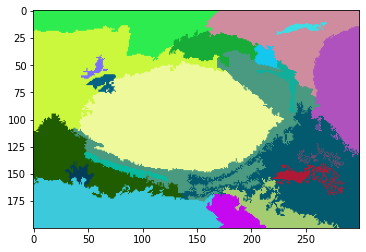

In [12]:
print("cluster num: " + str(num_cluster))
plt.imshow(res)